In [13]:
import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer
import numpy as np
import copy
import math
%matplotlib inline

In [53]:
class Moving_Point:
    
    acceleration=10
    timestep=0.1
    
    def __init__(self,height):
        self.previous_velocity=0
        self.current_velocity=0
        self.time=Moving_Point.timestep
        self.distance_crossed=0
        self.height=height
        self.t_max=math.sqrt(2*self.height/10)
        self.v_max=-self.t_max*10

    
    def advance_step(self,timestep):
        new_velocity=0
        a=Moving_Point.acceleration
        h=Moving_Point.timestep
        v_max=self.v_max
        
        if self.distance_crossed < self.height and  self.current_velocity <= 0:
            new_velocity=self.current_velocity-a*h
            self.distance_crossed+=abs(self.current_velocity)*h+0.5*a*(h)**2
            if self.distance_crossed > self.height:
                self.distance_crossed=self.height
                new_velocity=-v_max
                self.current_velocity=0
        elif self.current_velocity > 0 :
                new_velocity=self.current_velocity-a*h
                self.distance_crossed-=abs(self.current_velocity)*h-0.5*a*(h)**2
        self.previous_velocity=self.current_velocity
        self.current_velocity=new_velocity
        self.time+=h
        return self.current_velocity,self.previous_velocity,self.height-self.distance_crossed,self.time
    
   
    

In [54]:
p=Moving_Point(100)
p2=Moving_Point(200)

In [55]:
p.v_max

-44.721359549995796

In [56]:
distances=[]
v_current=[]
v_previous=[]
nb_of_training_points=400
for i in range(nb_of_training_points):
    if i>nb_of_training_points/2:
        current_speed,prev_speed,distance,time = p.advance_step(p.time)
    #print("Distance from collider is: {0}, current velocity is :{1}, previous velocity is : {2}, time :{3}".format(distance
    #                                                                                                   ,current_speed,
     #                                                                                                 prev_speed,time))
    else:
        p2.height=200
        current_speed,prev_speed,distance,time = p2.advance_step(p2.time)

    v_previous.append(prev_speed)
    v_current.append(current_speed)
    distances.append(distance)

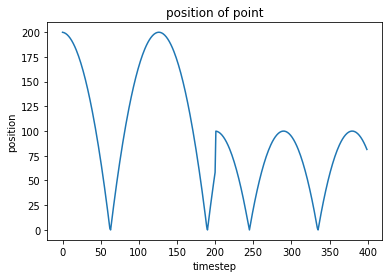

In [52]:
plt.title('position of point')
plt.xlabel('timestep')
plt.ylabel('position')
plt.plot(distances)

In [38]:
len(v_previous)

0

In [20]:
v_2_previous=[]
v_2_previous=copy.copy(v_previous)
v_2_previous.insert(0,0)
v_2_previous.pop()
len(v_2_previous)

400

In [21]:
# Convert to numpy array for torch #
v_current=np.array(v_current)
v_previous=np.array(v_previous)
v_2_previous=np.array(v_2_previous)
distances=np.array(distances)


In [22]:

X=np.array([v_2_previous,v_previous,distances]).T
Y=np.array(v_current).T


In [23]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

In [24]:
# Convert to pytorch tensors

X_tensor=torch.from_numpy(X).type(torch.FloatTensor)
Y_tensor=torch.from_numpy(Y).type(torch.FloatTensor)

# Convert to pytorch variables
X_variable=Variable(X_tensor,requires_grad=False)
Y_variable=Variable(Y_tensor,requires_grad=False)


In [25]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.fc2 = torch.nn.Linear(n_hidden, n_hidden)   # hidden layer
        self.fc3 = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))      # activation function for hidden layer
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    
    


In [26]:
# Set hyperparameters #
net = Net(n_feature=3, n_hidden=10, n_output=1)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=0.0001,momentum=0.9)
loss_func = torch.nn.MSELoss(size_average=True)  





Net(
  (fc1): Linear(in_features=3, out_features=10)
  (fc2): Linear(in_features=10, out_features=10)
  (fc3): Linear(in_features=10, out_features=1)
)


In [32]:
# Train the network #
for t in range(13500):
    out = net(X_variable)                 # input x and predict based on x
    loss = loss_func(out, Y_variable)     # must be (1. nn output, 2. target), the target label is NOT one-hotted

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    print(t,loss.data[0])
    optimizer.step()        # apply gradients


0 2.993645429611206
1 2.991429090499878
2 2.98921275138855
3 2.986995220184326
4 2.984774112701416
5 2.9825446605682373
6 2.980304479598999
7 2.978062629699707
8 2.9758214950561523
9 2.9735794067382812
10 2.97135066986084
11 2.9691271781921387
12 2.966904401779175
13 2.964688777923584
14 2.9624741077423096
15 2.960251569747925
16 2.958040475845337
17 2.9558160305023193
18 2.953598976135254
19 2.9513888359069824
20 2.949164628982544
21 2.946953535079956
22 2.944748878479004
23 2.9425442218780518
24 2.9403412342071533
25 2.938145637512207
26 2.935950994491577
27 2.93375301361084
28 2.93155574798584
29 2.9293646812438965
30 2.9271719455718994
31 2.9249842166900635
32 2.9227874279022217
33 2.9206061363220215
34 2.918428897857666
35 2.9162445068359375
36 2.914059638977051
37 2.911872625350952
38 2.9096834659576416
39 2.9075067043304443
40 2.9053282737731934
41 2.90315580368042
42 2.900977849960327
43 2.8988068103790283
44 2.896632671356201
45 2.894465923309326
46 2.8923003673553467
47 2.890

In [58]:
## creating test data ###

p_test=Moving_Point(150)
distances_test=[]
v_current_test=[]
v_previous_test=[]
for i in range(1):
    current_speed,prev_speed,distance,time = p_test.advance_step(0)

    v_previous_test.append(prev_speed)

    v_current_test.append(current_speed)
    distances_test.append(distance)




    v_2_previous_test=[]
    v_2_previous_test=copy.copy(v_previous_test)
    v_2_previous_test.insert(0,0)
    v_2_previous_test.pop()    
        

# Convert to numpy array for torch #
v_current_test=np.array(v_current_test)
v_previous_test=np.array(v_previous_test)
v_2_previous_test=np.array(v_2_previous_test)
distances_test=np.array(distances_test)
X_test=np.array([v_2_previous_test,v_previous_test,distances_test]).T
X_tensor_test=torch.from_numpy(X_test).type(torch.FloatTensor)
X_variable_test=Variable(X_tensor_test,requires_grad=False)
Y_predict=net(X_variable_test)
v_current_speed=Y_predict.data[0]
len(Y_predict)

1

In [57]:
v_current_speed


-1.3530
[torch.FloatTensor of size 1]

In [1]:
plt.scatter(Y_predict.data,distances_test,marker='x',color='r')
plt.scatter(v_current,distances,marker='o',color='b')


NameError: name 'plt' is not defined

ModuleNotFoundError: No module named 'pygame'